# Logistic Regression interpretability notebook

In [2]:
#Import statements
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from regressors import stats
from sklearn import tree
from dtreeviz.trees import *
from pycaret import classification

### Exploratory data analysis
Import to specify correctly the data path. Initally we can make an easy exploration.

In [3]:
data_folder_path = os.path.join('/', '')
data_file = 'ds.csv'

In [4]:
df = pd.read_csv(os.path.join(data_folder_path, data_file))
df.describe()

,Passes,Successful_passes,Unsuccessful_passes,Crosses,Successful_crosses,Unsuccessful_crosses,Long_passes,Long_passes_won,Long_passes_lost,Aerial,...,Interceptions,Saves,Clearances,Shots,Shots_on_target,Shots_off_target,Goals,Goals_from_penalty,Own_goals,gender
count,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,...,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000,4211.000000
mean,15.298741,12.306103,2.992638,0.584659,0.168131,0.265970,1.490857,0.721206,0.769651,1.528378,...,1.276656,0.161719,0.507005,0.451912,0.150558,0.260746,0.038946,0.005699,0.000950,0.641178
std,10.781397,9.955202,2.360038,1.053731,0.468728,0.609527,1.943403,1.158742,1.246045,1.948954,...,1.601120,0.614332,1.155853,0.790233,0.415994,0.565371,0.199532,0.075288,0.030809,0.479712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,10.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,21.000000,17.000000,4.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,2.000000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,70.000000,68.000000,17.000000,9.000000,4.000000,6.000000,16.000000,10.000000,13.000000,15.000000,...,11.000000,8.000000,11.000000,8.000000,4.000000,5.000000,2.000000,1.000000,1.000000,1.000000


### Classification Set-up
Definition of main model hyperparameters. Numeric features and target with full description available.

In [6]:
classification_setup = classification.setup(
    data=df,
    target='gender',
    numeric_features=[c for c in df.columns if c not in ['gender', 'matchPeriod', 'PlayerType']]
)

Setup Succesfully Completed!


,Description,Value
0,session_id,3079
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(4211, 33)"
4,Missing Values,False
5,Numeric Features,30
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Initial exploration to understand general performance metrics for different classification algorithms (Focus at Accuracy and AUC)

In [ ]:
classification.compare_models()

Logistic Regression training and evaluation with a 10-fold cross validation.

In [7]:
lr_model = classification.create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9661,0.9955,0.9630,0.9838,0.9733,0.9270,0.9274
1,0.9254,0.9838,0.9418,0.9418,0.9418,0.8380,0.8380
2,0.9559,0.9969,0.9683,0.9632,0.9657,0.9041,0.9041
3,0.9695,0.9933,0.9735,0.9787,0.9761,0.9339,0.9339
4,0.9695,0.9945,0.9683,0.9839,0.9760,0.9341,0.9344
5,0.9390,0.9877,0.9683,0.9385,0.9531,0.8658,0.8667
6,0.9492,0.9898,0.9471,0.9728,0.9598,0.8907,0.8913
7,0.9592,0.9929,0.9735,0.9634,0.9684,0.9107,0.9108
8,0.9592,0.9914,0.9788,0.9585,0.9686,0.9104,0.9108
9,0.9354,0.9825,0.9630,0.9381,0.9504,0.8578,0.8584


In [7]:
tuned_lr_model = classification.tune_model(lr_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9390,0.9889,0.9577,0.9476,0.9526,0.8669,0.8670
1,0.9254,0.9872,0.9418,0.9418,0.9418,0.8380,0.8380
2,0.9492,0.9896,0.9471,0.9728,0.9598,0.8907,0.8913
3,0.9661,0.9974,0.9735,0.9735,0.9735,0.9264,0.9264
4,0.9559,0.9924,0.9683,0.9632,0.9657,0.9041,0.9041
5,0.9525,0.9924,0.9577,0.9679,0.9628,0.8974,0.8974
6,0.9627,0.9939,0.9841,0.9588,0.9713,0.9182,0.9188
7,0.9286,0.9809,0.9206,0.9667,0.9431,0.8474,0.8492
8,0.9558,0.9915,0.9683,0.9632,0.9657,0.9035,0.9035
9,0.9422,0.9878,0.9577,0.9526,0.9551,0.8738,0.8738


In [ ]:
tuned_lr_model

In [9]:
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2131, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
X_train = classification_setup[2]

In [40]:
# Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
predProbs = lr_model.predict_proba(X_train)

# Design matrix -- add column of 1's at the beginning of your X_train matrix
X_design = np.hstack([np.ones((X_train.shape[0], 1)), X_train])

# Initiate matrix of 0's, fill diagonal with each predicted observation's variance
V = np.diagflat(np.product(predProbs, axis=1))

# Covariance matrix
# Note that the @-operater does matrix multiplication in Python 3.5+, so if you're running
# Python 3.5+, you can replace the covLogit-line below with the more readable:
covLogit = np.linalg.inv(X_design.T @ V @ X_design)
print("Covariance matrix: ", covLogit)
std_error = np.sqrt(np.diag(covLogit))
print("Standard errors: ", np.sqrt(np.diag(covLogit)))
# Wald statistic (coefficient / s.e.) ^ 2
logitParams = np.insert(lr_model.coef_, 0, lr_model.intercept_)
print("Wald statistics: ", (logitParams / np.sqrt(np.diag(covLogit))) ** 2)

Covariance matrix:  [[-1.75084936e+13  4.85097607e+11 -4.53111923e+11 ...  1.15788864e+13
   1.09862624e+13  8.27896219e+12]
 [-8.15206808e+11 -6.51756512e+10  6.24354160e+10 ... -7.42699569e+11
  -9.20963053e+11 -1.40643556e+12]
 [ 8.15206808e+11  6.51756512e+10 -6.24354160e+10 ...  7.42699569e+11
   9.20963053e+11  1.40643556e+12]
 ...
 [-2.91868443e+13 -6.19067092e+11  6.19067092e+11 ... -2.71081511e+13
  -2.71081511e+13 -2.71081511e+13]
 [-2.91868443e+13 -6.19067092e+11  6.19067092e+11 ... -2.71081511e+13
  -2.71081511e+13 -2.71081511e+13]
 [-2.91868443e+13 -6.19067092e+11  6.19067092e+11 ... -2.71081511e+13
  -2.71081511e+13 -2.71081511e+13]]
Standard errors:  [           nan            nan            nan            nan
 3.12483021e-01 4.26420301e-01 4.21361985e-01            nan
            nan            nan            nan            nan
            nan 4.03142815e-01 4.12089856e-01 4.14970473e-01
 1.25828430e-01 2.56490137e-01 2.62978820e-01 2.81641009e+07
 2.63536906e+07 2.879

In [39]:
len(std_error)

44

In [22]:
classification.save_model(lr_model, 'lr_6_10')

Transformation Pipeline and Model Succesfully Saved


In [ ]:
plot_options = ["auc","threshold","pr","confusion_matrix","error","class_report","boundary","rfe","learning","manifold","calibration","vc","dimension","feature","parameter"]
classification.plot_model(lr_model, plot='feature', save=True)

In [18]:
classification_setup[1]

0       1
1       1
2       1
3       1
4       1
       ..
4206    0
4207    0
4208    0
4209    0
4210    0
Name: gender, Length: 4211, dtype: int64

In [8]:
coef_df = pd.DataFrame({'Feature': classification_setup[0].columns, 'Weight': lr_model.coef_[0], 'Odds ratio': np.exp(lr_model.coef_[0])})

In [21]:
coef_df.sort_values(by=['Odds ratio'], ascending=False).head(15)

,Feature,Weight,Odds ratio
12,Ground_duels,3.437879,31.120883
26,Shots_off_target,1.729483,5.637738
25,Shots_on_target,1.362818,3.907190
39,PlayerType_Goalkeeper,1.260011,3.525461
3,Crosses,1.183030,3.264250
21,Interceptions,1.145644,3.144466
33,matchPeriod_E2,1.091627,2.979119
4,Successful_crosses,1.057305,2.878603
27,Goals,0.840976,2.318628
32,matchPeriod_E1,0.733228,2.081790


In [10]:
coef_df.reindex(coef_df.Weight.abs().sort_values(ascending=False).index).head(12)

,Feature,Weight,Odds ratio
12,Ground_duels,3.437879,31.120883
13,Ground_duels_won,-3.173241,0.041868
14,Ground_duels_lost,-2.793724,0.061193
5,Unsuccessful_crosses,-2.616411,0.073065
23,Clearances,-2.204146,0.110345
24,Shots,-1.758837,0.172245
26,Shots_off_target,1.729483,5.637738
17,Fouls_conceded,-1.701724,0.182369
16,Fouls_received,-1.462412,0.231677
25,Shots_on_target,1.362818,3.907190


<AxesSubplot:xlabel='Feature'>

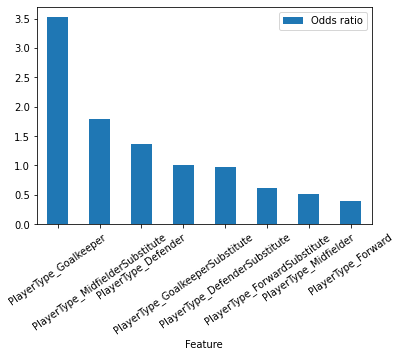

In [12]:
coef_df[coef_df['Feature'].isin(
    [
        'PlayerType_Defender', 'PlayerType_DefenderSubstitute','PlayerType_Forward', 
        'PlayerType_ForwardSubstitute','PlayerType_Goalkeeper', 'PlayerType_GoalkeeperSubstitute',
        'PlayerType_Midfielder', 'PlayerType_MidfielderSubstitute'
    ]
)].sort_values(by=['Odds ratio'], ascending=False).plot.bar(x='Feature', y='Odds ratio', rot=35)

### Scientific Reporting

In [16]:
coef_df[coef_df['Feature'].isin(
    [
        'PlayerType_Defender', 'PlayerType_DefenderSubstitute','PlayerType_Forward', 
        'PlayerType_ForwardSubstitute','PlayerType_Goalkeeper', 'PlayerType_GoalkeeperSubstitute',
        'PlayerType_Midfielder', 'PlayerType_MidfielderSubstitute'
    ]
)].sort_values(by=['Odds ratio'], ascending=False).head(100).to_latex(index=False)

'\\begin{tabular}{lrr}\n\\toprule\n                         Feature &    Weight &  Odds ratio \\\\\n\\midrule\n           PlayerType\\_Goalkeeper &  1.260011 &    3.525461 \\\\\n PlayerType\\_MidfielderSubstitute &  0.578782 &    1.783865 \\\\\n             PlayerType\\_Defender &  0.309324 &    1.362504 \\\\\n PlayerType\\_GoalkeeperSubstitute &  0.000000 &    1.000000 \\\\\n   PlayerType\\_DefenderSubstitute & -0.035701 &    0.964928 \\\\\n    PlayerType\\_ForwardSubstitute & -0.478682 &    0.619600 \\\\\n           PlayerType\\_Midfielder & -0.656056 &    0.518894 \\\\\n              PlayerType\\_Forward & -0.935120 &    0.392539 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [17]:
coef_df[coef_df['Feature'].isin(
    [
        'matchPeriod_1H', 'matchPeriod_2H',
        'matchPeriod_E1', 'matchPeriod_E2',
        'matchPeriod_P'
    ]
)].sort_values(by=['Odds ratio'], ascending=False).head(100).to_latex(index=False)

'\\begin{tabular}{lrr}\n\\toprule\n        Feature &    Weight &  Odds ratio \\\\\n\\midrule\n matchPeriod\\_E2 &  1.091627 &    2.979119 \\\\\n matchPeriod\\_E1 &  0.733228 &    2.081790 \\\\\n matchPeriod\\_2H & -0.477029 &    0.620625 \\\\\n matchPeriod\\_1H & -0.516509 &    0.596600 \\\\\n  matchPeriod\\_P & -0.788760 &    0.454408 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
coef_df.to_csv('coef.csv')

In [11]:
classification_setup[2].columns

Index(['Passes', 'Successful_passes', 'Unsuccessful_passes', 'Crosses',
       'Successful_crosses', 'Unsuccessful_crosses', 'Long_passes',
       'Long_passes_won', 'Long_passes_lost', 'Aerial', 'Aerial_won',
       'Aerial_lost', 'Ground_duels', 'Ground_duels_won', 'Ground_duels_lost',
       'Free_kicks', 'Fouls_received', 'Fouls_conceded', 'Corners',
       'Corners_successful', 'Corners_unsuccessful', 'Interceptions', 'Saves',
       'Clearances', 'Shots', 'Shots_on_target', 'Shots_off_target', 'Goals',
       'Goals_from_penalty', 'Own_goals', 'matchPeriod_1H', 'matchPeriod_2H',
       'matchPeriod_E1', 'matchPeriod_E2', 'matchPeriod_P',
       'PlayerType_Defender', 'PlayerType_DefenderSubstitute',
       'PlayerType_Forward', 'PlayerType_ForwardSubstitute',
       'PlayerType_Goalkeeper', 'PlayerType_GoalkeeperSubstitute',
       'PlayerType_Midfielder', 'PlayerType_MidfielderSubstitute'],
      dtype='object')